In [1]:
import re
import os
import sys
import json

# add the parent directory of main.py to Python path to enable import modules from the wikibase package.
notebook_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, parent_dir)

import wikibase_injector.data_formatter.data_culture_api as data_culture_api
import wikibase_injector.data_formatter.data_loire_web as data_loire_web
import wikibase_injector.data_formatter.data_clic_csv as data_clic_csv

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from nltk.stem import WordNetLemmatizer, PorterStemmer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import DBSCAN, KMeans
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import unidecode
import nltk

In [3]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

## Export all data into JSON

In [ ]:
#  # L'API ne contient que des musées
# _, data_api = data_culture_api.retrieve_data()
_, data_csv = data_clic_csv.retrieve_data()
# _, data_web = data_loire_web.retrieve_data()
# data_web.extend(data_csv)

# Écriture des données dans un nouveau fichier JSON avec les labels de cluster ajoutés
with open('dataset.json', 'w') as f:
    json.dump(data_csv, f, indent=2)

## Clustering

#### Etape de Pre-processing des données

In [12]:
# Initialisation des outils de prétraitement
stop_words = set(stopwords.words('french'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Liste des mots clés
keywords = ['eglise', 'musee', 'maison', 'immeuble', 'Chapelle', 'château']

# Fonction de prétraitement des données
def preprocess(text, label=False):
    text = unidecode.unidecode(text) # Suppression des accents
    text = re.sub(r'[^\w\s]', '', text) # Suppression des caractères spéciaux
    text = text.lower() # Conversion en minuscules

    tokens = nltk.word_tokenize(text) # Tokenisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatisation
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens] # Stemming
    stop_tokens = [token for token in stemmed_tokens if token not in stop_words] # Suppression des mots vides

    if not label:
        # Retourner les mots clés si présents, sinon retourner stop_tokens
        cleaned_tokens = [token for token in stop_tokens if token in keywords] or stop_tokens
    else:
        cleaned_tokens = stop_tokens
    
    text = ' '.join(cleaned_tokens) # Réassemblage du texte pré-traité
    return text

keywords = [preprocess(keyword, label=True) for keyword in keywords]

In [13]:
# Chargement des données à partir du fichier JSON
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Extraction de la colonne "name" 
names = [d['name'] for d in data]

# Application de la fonction preprocess sur les noms et descriptions de monuments
clean_names = [preprocess(name) for name in names]

#### Création de la matrice TF-IDF à partir des noms de monuments prétraités

In [14]:
# Création de la matrice TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(clean_names)
tfidf_matrix = tfidf_matrix.toarray()

#### Création de la matrice de représentation sémantique à partir de données prétraitées avec Word2Vec

In [ ]:
vector_size = len(data)
processed_data = clean_names

# Entraînement du modèle Word2Vec sur les données prétraitées
model = Word2Vec(processed_data, vector_size=vector_size, window=5, min_count=1, workers=4)

# Création de la matrice de représentation sémantique
representation_matrix = np.zeros((len(processed_data), vector_size))
for i, sentence in enumerate(processed_data):
    for word in sentence:
        representation_matrix[i] += model.wv[word]
    representation_matrix[i] /= len(sentence)

# Matrice de représentation sémantique
tfidf_matrix = model.wv.vectors.transpose()

### Nombre de Cluster Optimal

#### Elbow Method

cette méthode consiste à tracer la somme des carrés des distances intra-cluster en fonction du nombre de clusters. Le nombre optimal de clusters est situé à l'endroit où la courbe commence à s'aplatir, formant un "coude".

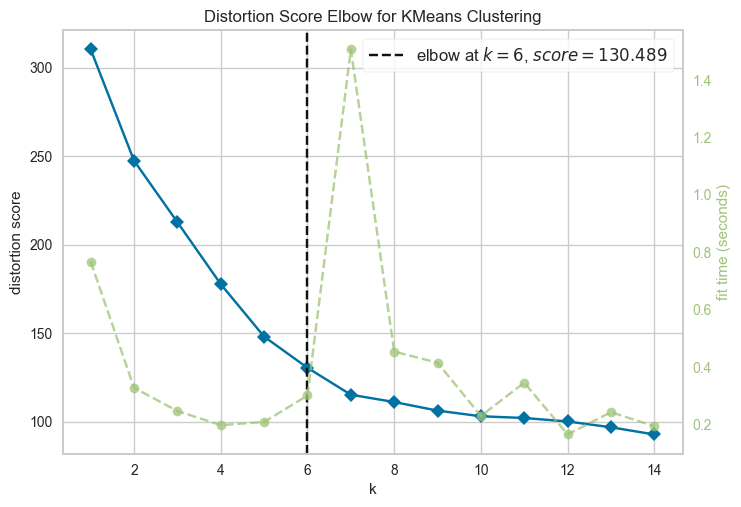

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(1, 15))

# Fit the visualizer to the TF-IDF matrix and plot the elbow curve
visualizer.fit(tfidf_matrix)
visualizer.show()

#### Silhouette Method

cette méthode mesure à la fois la cohérence des clusters et leur séparation. Elle calcule le score de silhouette moyen pour chaque nombre de clusters et le maximum de ces scores indique le nombre optimal de clusters.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
rng = range(2, 16)
for k in rng:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, labels)
    silhouette_scores.append(score)

plt.plot(rng, silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette moyen')
plt.title('Méthode de la silhouette')
plt.show()

## Clustering

In [16]:
n_clusters = 6 # Nombre de clusters choisi arbitrairement

### Approche avec AgglomerativeClustering

In [ ]:
# Clustering hiérarchique
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean').fit(tfidf_matrix)

# Trouver les hauteurs de fusion de la hiérarchie de clustering
Z = linkage(tfidf_matrix, method='ward')

# Trouver les indices des échantillons dans chaque cluster
labels = fcluster(Z, n_clusters, criterion='maxclust')

# Trouver les centres de cluster
cluster_centers = []
for i in range(1, n_clusters+1):
    idx = np.where(labels == i)[0]
    center = np.mean(tfidf_matrix[idx], axis=0)
    cluster_centers.append(center)

cluster_centers = np.vstack(cluster_centers)

# Calcul des distances entre les centres de cluster et les points dans tfidf_matrix
distances = euclidean_distances(tfidf_matrix, cluster_centers)

# Récupération de l'indice de l'élément le plus proche
cluster_labels = distances.argmin(axis=1)

# Ajout d'une nouvelle colonne pour stocker les labels de cluster associés aux noms de monument
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

# Écriture des données dans un nouveau fichier JSON avec les labels de cluster et les coordonnées des centres de cluster ajoutés
with open('./donnees_clusterisees.json', 'w') as f:
    json.dump(data, f, indent=2)

### Approche avec K-Means

In [17]:
# K-Means Clustering

# Spécification du nombre maximum d'itérations
max_iter = 500

# Initialisation du K-Means
kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42, n_init=10).fit(tfidf_matrix)

# Récupération des labels de cluster pour chaque échantillon
cluster_labels = kmeans.labels_

# Récupération des centres de cluster
cluster_centers = kmeans.cluster_centers_

# Ajout d'une nouvelle colonne pour stocker les labels de cluster associés aux noms de monument
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

# Écriture des données dans un nouveau fichier JSON avec les labels de cluster et les coordonnées des centres de cluster ajoutés
with open('./donnees_clusterisees.json', 'w') as f:
    json.dump(data, f, indent=2)

### Approche avec DBSCAN

In [ ]:
# DBSCAN Clustering

eps = 0.8 # Distance maximale entre les échantillons pour être considérés comme appartenant au même cluster
min_samples = 4 # Nombre minimum d'échantillons pour former un cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(tfidf_matrix)

# Ajout d'une nouvelle colonne pour stocker les labels de cluster associés aux noms de monument
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

# Écriture des données dans un nouveau fichier JSON avec les labels de cluster ajoutés
with open('./donnees_clusterisees.json', 'w') as f:
    json.dump(data, f, indent=2)

## PLOT Monument / Label

### Nombre de monument par cluster

In [ ]:
# Compter le nombre de monuments dans chaque cluster
labels = [d['label'] for d in data]
counts = pd.Series(labels).value_counts()

# Tracer un graphique en barres
fig, ax = plt.subplots(figsize=(10, 8))
counts.plot(kind='bar', ax=ax)

# Configuration des axes et du titre
ax.set_xlabel('Cluster Label', fontsize=12)
ax.set_ylabel('Number of Monuments', fontsize=12)
ax.set_title('Monument Clustering', fontsize=14)

# Affichage du plot
plt.show()

### Représentation des monuments/Cluster 

In [18]:
# Extraction des labels de cluster et des noms de monuments
labels = [d['label'] for d in data]
names = [d['name'] for d in data]

# Création de la figure
fig = go.Figure()

# Ajout des points sur la figure avec les noms des monuments en survolant les points
fig.add_trace(go.Scatter(x=labels, y=list(range(len(data))),
                    mode='markers',
                    text=names,
                    hovertemplate='<b>%{text}</b>',
                    marker=dict(
                        size=10,
                        color=labels,
                        colorscale='Viridis',
                        line_width=0.5)))

# Configuration des marges et des titres de la figure
fig.update_layout(title='Monument Clustering',
                xaxis_title='Cluster Label',
                yaxis_title='Monument',
                margin=dict(l=50, r=50, t=50, b=50))

fig.update_layout(height=800)
# Affichage de la figure
fig.show()